## Graph RAG

источники:
- [Microsoft GraphRAG](https://github.com/microsoft/graphrag)
- [промпты Microsoft](https://github.com/microsoft/graphrag/blob/main/graphrag/prompt_tune/prompt/entity_relationship.py)
- [Примеры реализации RAG](https://github.com/yandex-datasphere/advanced_rag/tree/main)

In [1]:
import os
from yandex_chain import YandexLLM, YandexGPTModel
llm = YandexLLM(folder_id=os.environ['YANDEX_FOLDER_ID'],
                api_key=os.environ['YANDEX_API_KEY'],
                model=YandexGPTModel.Pro)

text = """
Хирургическое  лечение мужчинам  с АБА рекомендуется при диаметре  аневризмы  55,5 см у мужчин 27  У женщин с  АБА и  приемлемым хирургичес ким риском оперативное вмешательство может быть рекомендовано при диаметре АБА ≥ 4,55,0 см;  При быстром росте АБА – более 1,0 см в год рекомендовано срочное обращение к сосудистому хирургу для дополнительного обследования.
Пациентам с аневризматическим расширением синусов Вальсальвы и тубулярного отдела ВА (в том числе ассоциированным с синдромами М арфана, Лойеса Дитца, ЭлерсаДанло) рекомендуется выполнять протезирование корня и ВА с реимплантацией АК (операция David ), а при невозможности – операцию Bentall  – De Bono.
"""

In [2]:
entity_extraction_prompt = """
# Цель
Тебе на вход даётся текстовый документ. Сначала выдели все сущности, которые необходимы, чтобы передать всю содержащуются в тексте информацию и идеи. Далее, найди все связи между этими сущностями в тексте. 

# Шаги
1. Выдели все сущности. Для каждой найденной сущности, укажи:
- entity_name: Имя сущности, заглавными буквами
- entity_type: Предложи несколько категорий для сущности. Категории не должны быть конкретными, а должны быть наиболее общими. Особенно важно выделять из текста сущности являющиеся симптомами, заболеваниями, методами лечения, числовые и нечисловые характеристики пациента.
- entity_description: Подробное описание атрибутов сущности.
Не используй кавычки и другие знаки препинания в имени сущности. Удаляй лишние кавычки.
Выведи информацию о сущности в следующем виде (entity|<entity_name>|<entity_type>|<entity_description>)

2. Для всех сущностей, выделенных на шаге 1, выдели все связи, т.е. пары (исходная_сущность, целевая_сущность) которые *связаны* между собой.
Для каждой пары связанных сущностей, извлеки следующую информацию:
- source_entity: имя исходной сущности, как она найдена на шаге 1
- target_entity: имя целевой сущности, как она найдена на шаге 1
- relationship_name: короткое имя связи между сущностями
- relationship_description: описание того, как исходная сущность и целевая сущность связаны между собой. В связах могут участвовать только сущности, выделенные на шаге 1. 
 Выведи информацию о связях в следующем виде (relationship|<source_entity>|<target_entity>|<relationship_name>|<relationship_description>)

3. Выведи результат в виде списка, содержащего все сущности, найденные на шаге 1, и связи, найденные на шаге 2. Используй **перевод строки** как разделитель списка.

4. Когда закончишь, выведи [EOF]

######################
-Примеры-
######################
Текст:
Борщ — горячий заправочный суп на основе свёклы, которая придаёт ему характерный красный цвет.
В словаре В. И. Даля — род щей, похлёбка из квашеной свёклы, на говядине и свинине, или со свиным салом. Получило широкое распространение во многих национальных кухнях: это блюдо есть у русских, белорусов и др.
######################
Результат:
(entity|БОРЩ|БЛЮДО|горячий заправочный суп на основе свёклы)
(entity|ГОВЯДИНА|ИНГРЕДИЕНТ|Мясо коровы, входящее в состав борща)
(entity|СВИНИНА|ИНГРЕДИЕНТ|Мясо свиньи, входящее в состав борща)
(entity|ЩИ|БЛЮДО|вид первого блюда)
(entity|РУССКИЕ|НАРОД|проживающие в России)
(entity|БЕЛОРУСЫ|НАРОД|проживающие в Белоруссии)
(relationship|БОРЩ|ЩИ|ЧАСТНЫЙ_СЛУЧАЙ|Борщ является разновидностью Щей)
(relationship|БОРЩ|ГОВЯДИНА|СОДЕРЖИТ|Борщ может содержать говядину)
(relationship|БОРЩ|СВИНИНА|СОДЕРЖИТ|Борщ может содержать свинину)
(relationship|БОРЩ|РУССКИЕ|РАСПРОСТРАНЕНИЕ|Борщ распространён у русских)
(relationship|БОРЩ|БЕЛОРУСЫ|РАСПРОСТРАНЕНИЕ|Борщ распространён у белорусов)
[EOF]
######################
Текст:
Цифровой рубль  — цифровая валюта центрального банка, разрабатываемая Банком России (ЦБ РФ), третья форма российской национальной валюты в дополнение к уже существующим наличной и безналичной формам денег.
Цифровой рубль будет эмитироваться Банком России. Цифровой рубль сочетает в себе свойства наличных и безналичных рублей.
######################
Результат:
(entity|ЦИФРОВОЙ_РУБЛЬ|ВАЛЮТА|цифровая валюта центрального банка)
(entity|БАНК РОССИИ|БАНК|Центральный банк России)
(entity|НАЛИЧНАЯ|ФОРМА ДЕНЕГ|Деньги, распространяемые купюрами)
(entity|БЕЗНАЛИЧНАЯ|ФОРМА ДЕНЕГ|Деньги, распространяемые в электронном виде)
(relationship|ЦИФРОВОЙ РУБЛЬ|БАНК РОССИИ|ЭМИТИРУЕТСЯ|Цифровой рубль будет эмитироваться Банком России)
(relationship|ЦИФРОВОЙ РУБЛЬ|НАЛИЧНАЯ|ИМЕЕТ_СВОЙСТВА|Цифровой рубль имеет свойста наличных денег)
(relationship|ЦИФРОВОЙ РУБЛЬ|БЕЗНАЛИЧНАЯ|ИМЕЕТ_СВОЙСТВА|Цифровой рубль имеет свойста безналичных денег)
######################
-Реальные данные-
######################
Текст: {}
######################
Результат:
"""

res = llm.invoke(entity_extraction_prompt.format(text))
print(res)

(entity|АБА|ЗАБОЛЕВАНИЕ|аневризма брюшной аорты)
(entity|ДИАМЕТР|ЧИСЛОВАЯ_ХАРАКТЕРИСТИКА|55,5 см — характеристика аневризмы)
(entity|ХИРУРГИЧЕСКОЕ ЛЕЧЕНИЕ|МЕТОД ЛЕЧЕНИЯ|рекомендуется при диаметре аневризмы 55,5 см у мужчин)
(entity|ЖЕНЩИНЫ|ПАЦИЕНТ|у женщин с АБА и приемлемым хирургическим риском оперативное вмешательство может быть рекомендовано при диаметре АБА ≥ 4,5-5,0 см)
(entity|РОСТ|ЧИСЛОВАЯ ХАРАКТЕРИСТИКА |1,0 см в год — рост АБА, требующий обращения к сосудистому хирургу)
(entity|СОСУДИСТЫЙ ХИРУРГ|СПЕЦИАЛИСТ|к нему следует обратиться для дополнительного обследования при быстром росте АБА)
(entity|СИНУСЫ ВАЛЬСАЛЬВЫ|АНАТОМИЧЕСКАЯ СТРУКТУРА|место, где может произойти расширение)
(entity|ТУБУЛЯРНЫЙ ОТДЕЛ ВА|АНАТОМИЧЕСКАЯ СТРУКТУРА|ещё одно место возможного расширения)
(entity|МАРФАНА СИНДРОМ|ЗАБОЛЕВАНИЕ|связан с аневризматическим расширением синусов Вальсальвы и тубулярного отдела ВА)
(entity|ЛОЙЕСА ДИТЦА СИНДРОМ|ЗАБОЛЕВАНИЕ|связан с расширением)
(entity|ЭЛЕРСА-ДАНЛО СИНДРОМ|ЗАБОЛЕ

Возьмём информацию о регионах и сортах винограда:

In [3]:
from tqdm.auto import tqdm

with open('../source/dataset.txt',encoding='utf-8') as f:
    dataset = ''.join(f.readlines())

dataset = dataset.split('-----')

In [5]:
with open('raw/er.txt', 'w', encoding='utf-8') as f:
    for x in tqdm(dataset):
        res = llm.invoke(entity_extraction_prompt.format(x))
        f.write(res)

  0%|          | 0/473 [00:00<?, ?it/s]

In [6]:
import unicodedata


ACCENT_MAPPING = {
    '́': '',
    '̀': '',
    'а́': 'а',
    'а̀': 'а',
    'е́': 'е',
    'ѐ': 'е',
    'и́': 'и',
    'ѝ': 'и',
    'о́': 'о',
    'о̀': 'о',
    'у́': 'у',
    'у̀': 'у',
    'ы́': 'ы',
    'ы̀': 'ы',
    'э́': 'э',
    'э̀': 'э',
    'ю́': 'ю',
    '̀ю': 'ю',
    'я́́': 'я',
    'я̀': 'я',
}
ACCENT_MAPPING = {
    unicodedata.normalize('NFKC', i): j for i, j in ACCENT_MAPPING.items()
}


def unaccentify(s):
    source = unicodedata.normalize('NFKC', s)
    for old, new in ACCENT_MAPPING.items():
        source = source.replace(old, new)
    return source


def normalize(text):
    return (
        unaccentify(text)
    )

In [7]:
import re


with open('raw/er.txt', encoding='utf-8') as f:
    lines = f.readlines()

def add_entity(entities, name, kind, desc):
    if name in entities.keys():
        entities[name]['kind'].append(kind)
        entities[name]['desc'].append(desc)
    else:
        entities[name] = {'kind': [kind], 'desc': [desc]}


def extract_ER(lines):
    entities = {}
    relations = []
    for x in lines:
        x = normalize(x)
        if z := re.match(r'\((.*)\)', x):
            z = z.string.strip()[1:-1].split('|')
            z = [t.strip().lower() for t in z]

            if z[0] == 'entity':
                if len(z) < 4:
                    z.append('')
                else:
                    add_entity(entities, z[1], z[2], z[3])
            elif z[0] == 'relationship':
                while len(z) < 5:
                    z.append('')
                relations.append({
                    "source": z[1],
                    "target": z[2],
                    "relation": z[3],
                    "desc": z[4],
                })
            else:
                print(f'Invalid command: {z}')

    # Clean up relations with non-existing entities
    relations = [
        x for x in relations
        if x['source'] in entities.keys() and x['target'] in entities.keys()
    ]

    return entities, relations


entities, relations = extract_ER(lines)

print(f"Found {len(entities)} entities and {len(relations)} relations")

Found 1054 entities and 589 relations


In [8]:
import json


with open('graphs/entities.json', 'w', encoding='utf-8') as f:
    json.dump(entities, f, ensure_ascii=False, indent=4)

with open('graphs/relations.json', 'w', encoding='utf-8') as f:
    json.dump(relations, f, ensure_ascii=False, indent=4)

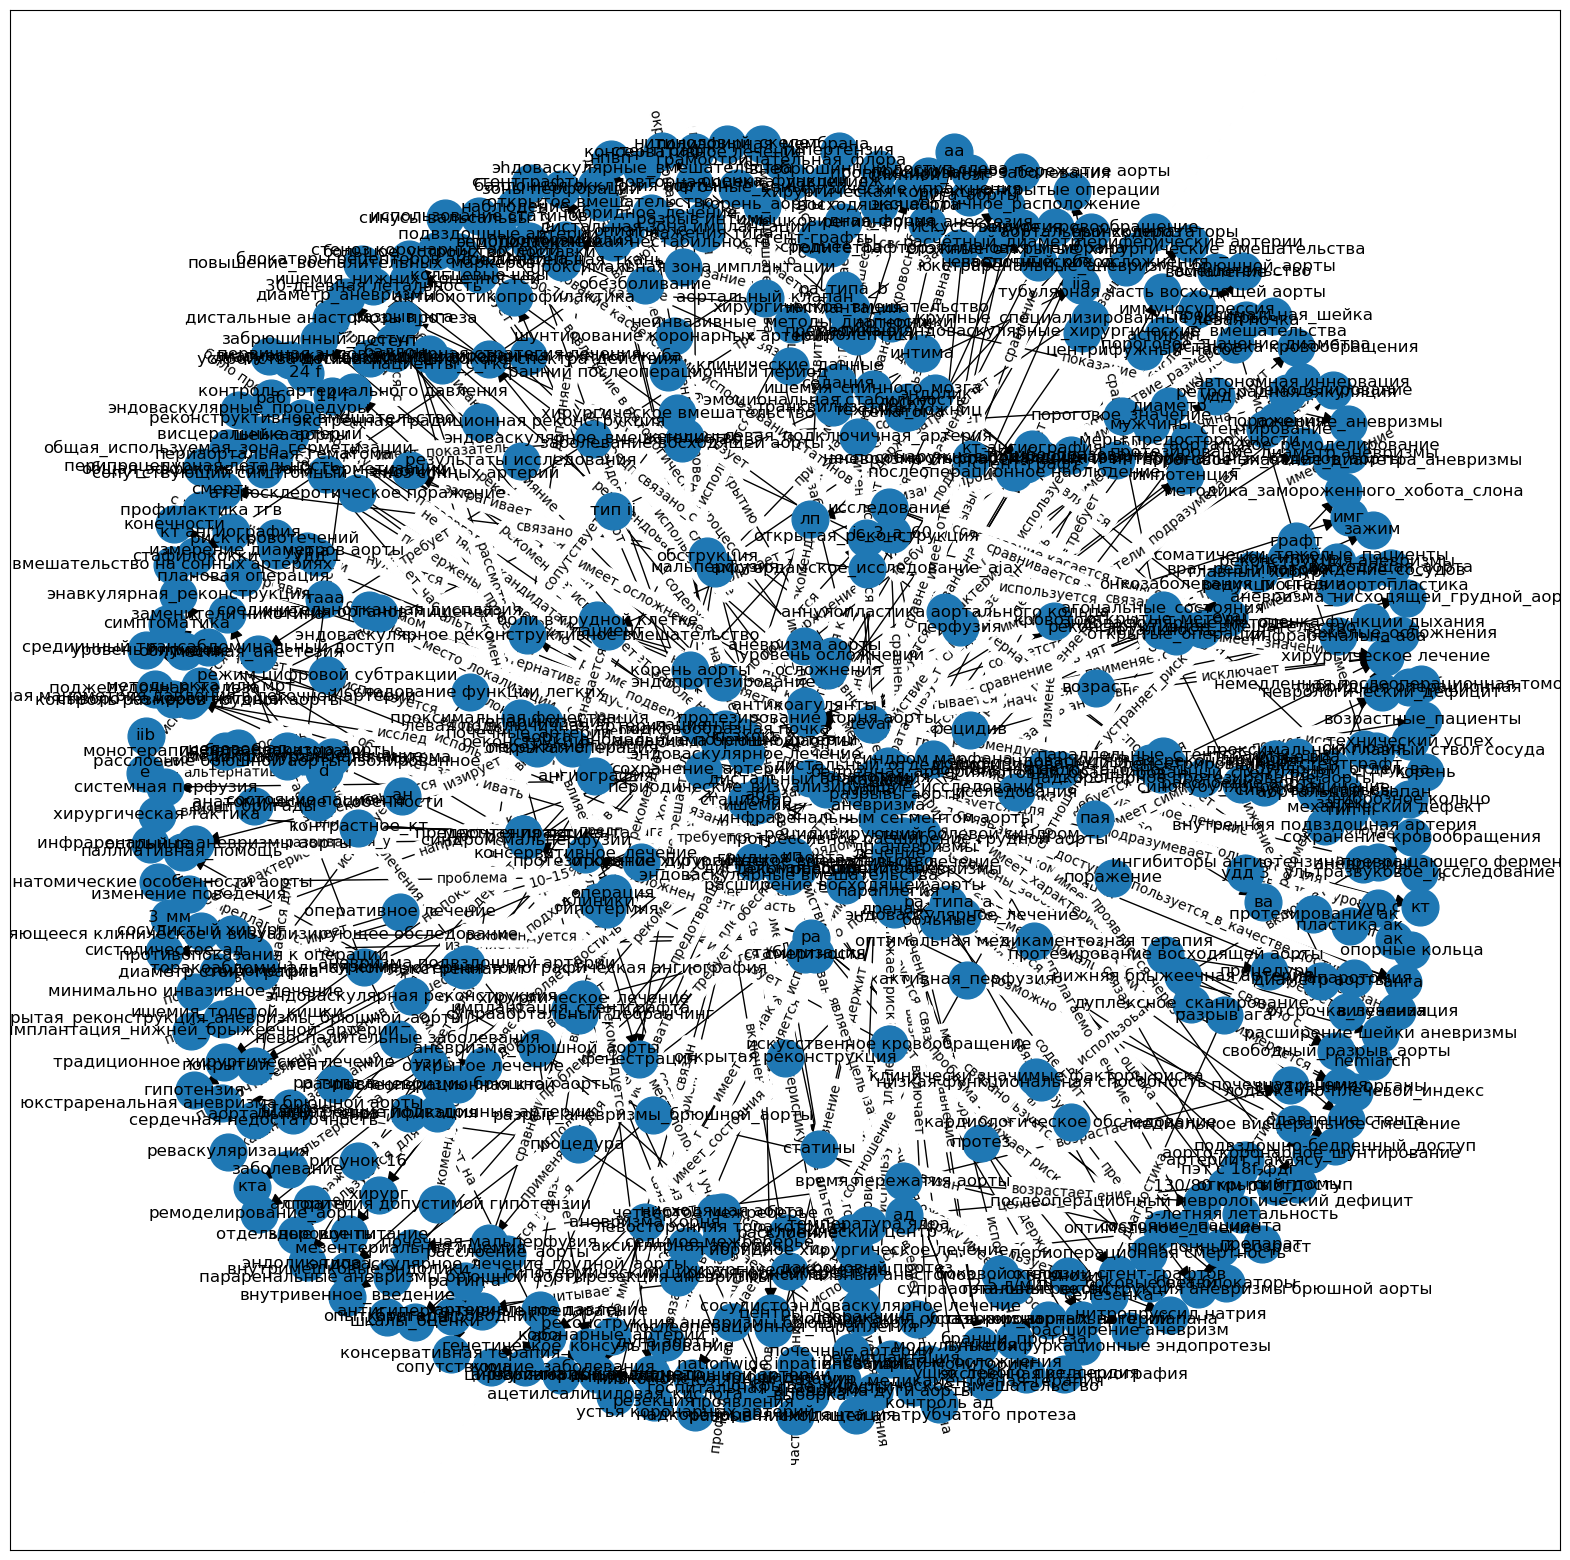

In [9]:
import networkx as nx
import matplotlib.pyplot as plt


# Create a directed graph
G = nx.DiGraph()

exist_entities = set(
    [r['source'] for r in relations] + [r['target'] for r in relations]
)

for e, v in entities.items():
    if e in exist_entities:
        G.add_node(e, label=e)

for r in relations:
    G.add_edge(r['source'], r['target'], label=r['relation'], desc=r['desc'])


def plot_graph(G):
    plt.figure(figsize=(20, 20))

    # Define node positions using a layout
    pos = nx.spring_layout(G)

    # Draw the nodes with labels
    nx.draw_networkx_nodes(G, pos, node_size=700)
    nx.draw_networkx_labels(
        G, pos, labels=nx.get_node_attributes(G, 'label'), font_size=12
    )

    # Draw the edges with labels
    nx.draw_networkx_edges(
        G, pos, edgelist=G.edges(), arrowstyle='-|>', arrowsize=20
    )
    nx.draw_networkx_edge_labels(
        G, pos, edge_labels=nx.get_edge_attributes(G, 'label')
    )

    # Display the graph
    plt.show()


plot_graph(G)

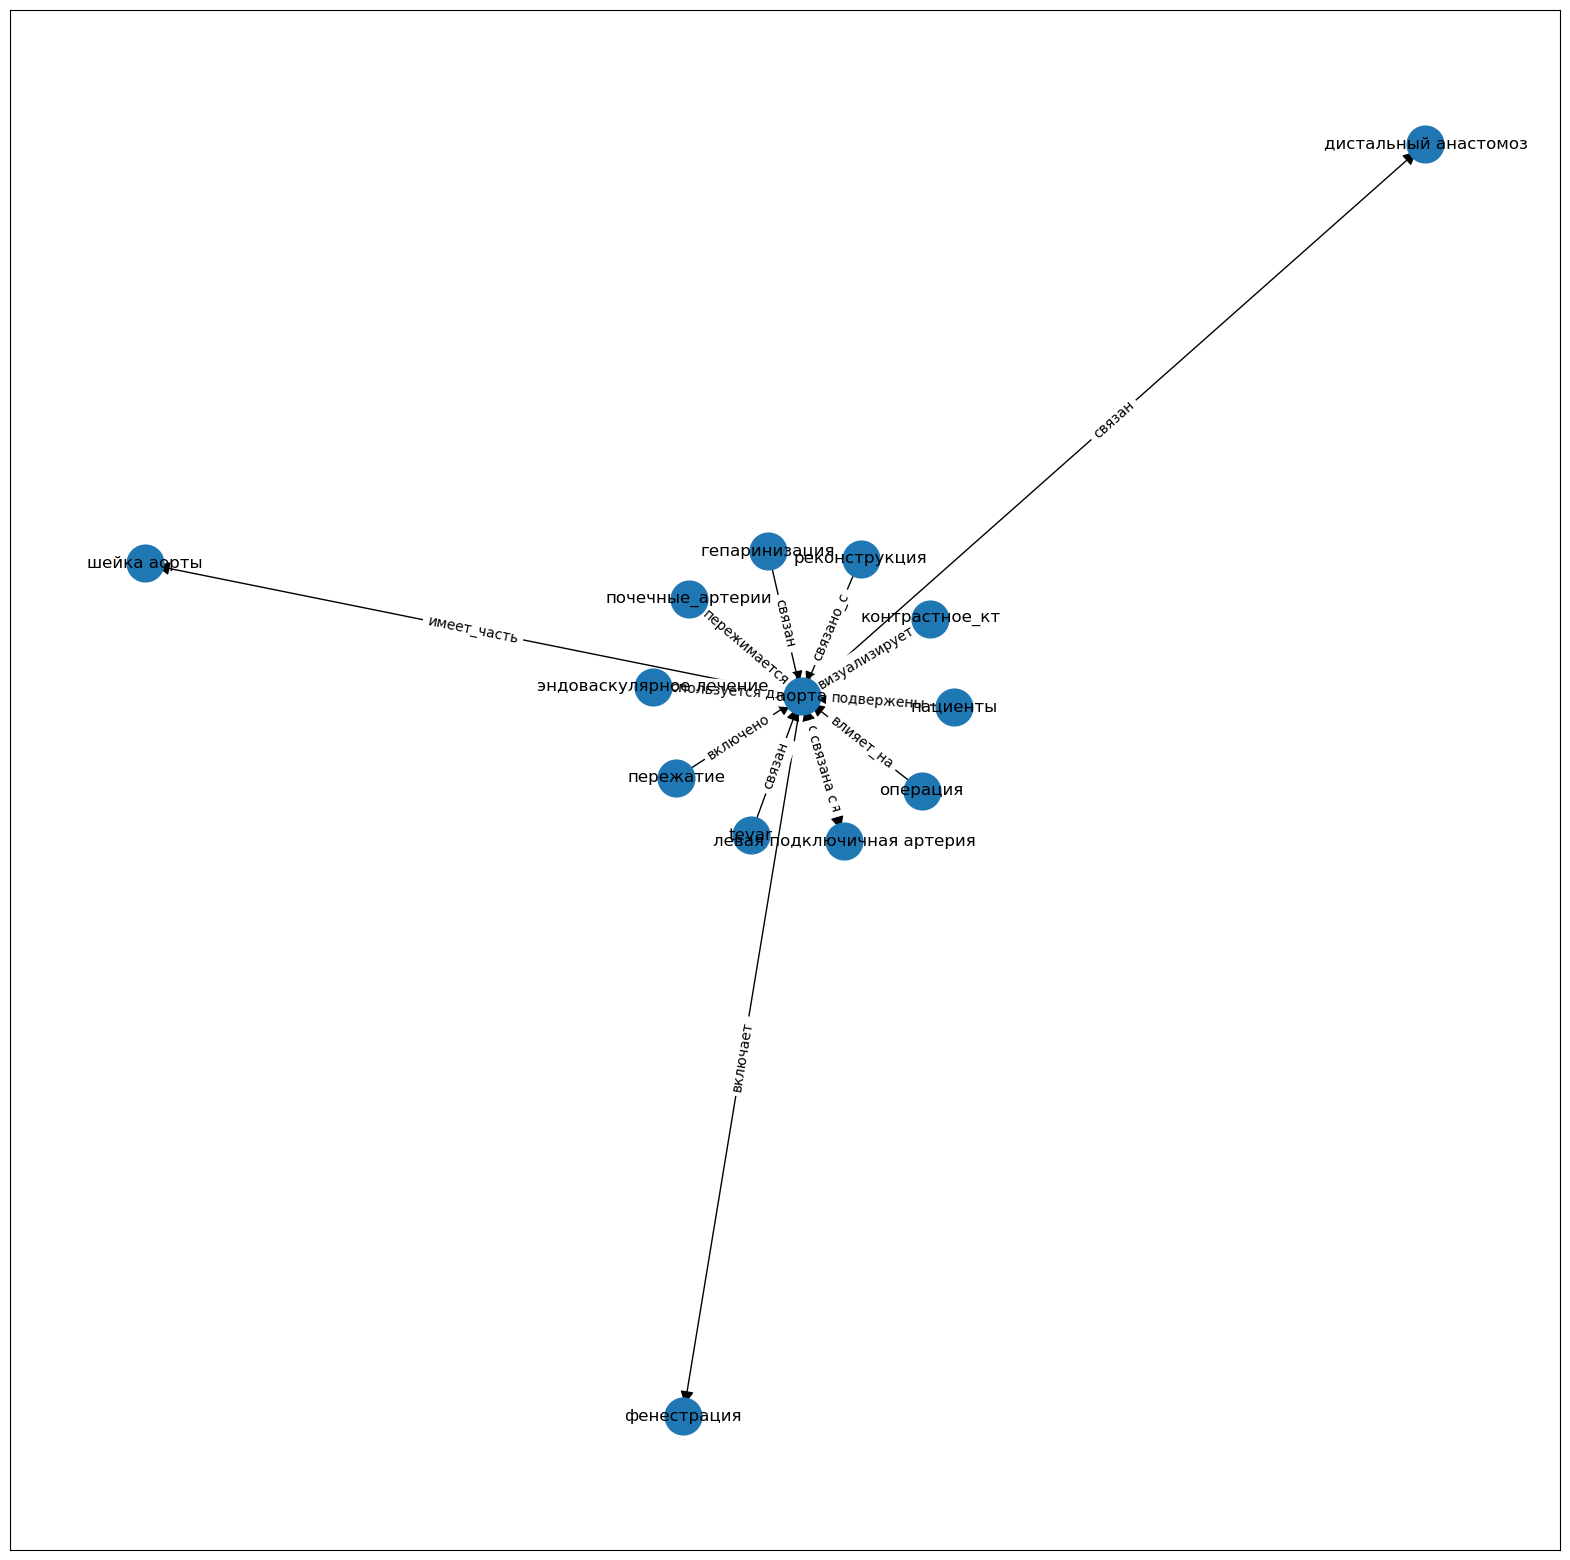

In [10]:
import networkx as nx
import matplotlib.pyplot as plt


# Create a directed graph
G = nx.DiGraph()


def populate_graph(G, e, level=None):
    if e in G.nodes:
        return
    if e in entities.keys():
        G.add_node(e, label=e)
    if level is not None and level <= 0:
        return
    new_ent = set(
        [r['source'] for r in relations if r['target'] == e] +
        [r['target'] for r in relations if r['source'] == e]
    )
    for ne in new_ent:
        populate_graph(G, ne, None if level is None else level-1)
    for r in relations:
        if r['source'] == e:
            G.add_edge(e, r['target'], label=r['relation'], desc=r['desc'])
        if r['target'] == e:
            G.add_edge(r['source'], e, label=r['relation'], desc=r['desc'])


populate_graph(G, 'аорта', 1)

plot_graph(G)

In [23]:
entity_lookup_prompt = """
Ниже в тройных обратных кавычках приводится короткий текст. Тебе необходимо выделить из него все сущности,
похожие на сущности из списка в двойных кавычках: "{list}". Верни только список сущностей в скобках
через запятую, например: (аневризма, АБА, диаметр, операция). Верни только те сущности, которые в явном виде
присутствуют в запросе (они могут быть написаны с опечатками или в другом падеже). Не придумывай никакие дополнительные сущности и не рассуждай.
--текст--
```
{}
```
""".replace('{list}', ', '.join(entities.keys()))


def process_q(txt):
    res = llm.invoke(entity_lookup_prompt.format(txt))
    if '(' in res and ')' in res:
        res = res[res.index('(')+1:res.index(')')]
        res = res.split(',')
        return [x.strip() for x in res]
    else:
        return None

['женщина', 'кровоток']


In [33]:
answer_prompt = """
Ты - кардиохирург. Пожалуйста, посмотри на текст (в тройных обратных кавычках) и симптомы больного ниже. Напиши краткое заключение с рекомендацией по лечению для больного.
```
{context}
```
Симптомы:
{simptoms}
Заключение:
"""


def create_context(G):
    return '\n'.join(
        e[-1]['desc'] for e in G.edges(data=True))

In [34]:
def get_answer(q):
    ents = process_q(q)
    print(ents)

    G = nx.DiGraph()
    for e in ents:
        populate_graph(G, e, 2)

    for e in G.edges(data=True):
        print(e)

    plot_graph(G)

    ans = llm.invoke(
        answer_prompt
        .replace('{context}', create_context(G))
        .replace('{simptoms}', q)
    )
    return ans

['АБА', 'диаметр']
('диаметр', 'пороговое значение диаметра', {'label': 'эквивалент', 'desc': 'пороговым значением диаметра является 5-5,5см'})
('аневризма_инфраренальных_и_интерренальных_отделов_аорты', 'диаметр', {'label': 'имеет_характеристику', 'desc': 'аневризма имеет определённый размер'})
('стент-графт', 'энд0подтекание', {'label': 'связан с', 'desc': 'стент-графт связан с возможным эндоподтеканием'})
('стент-графт', 'механический дефект', {'label': 'связан', 'desc': 'стент-графт связан с механическим дефектом'})
('стент-графт', 'проксимальная_шейка', {'label': 'соответствие_размера', 'desc': 'диаметр стент-графта должен превышать диаметр проксимальной шейки на 10–20%'})
('стент-графт', 'диаметр', {'label': 'зависимость', 'desc': 'диаметр стент-графта зависит от диаметра аорты и составляет 10-20% больше диаметра проксимальной шейки'})
('ип', 'стент-графт', {'label': 'требуется', 'desc': 'стент-графт устанавливается в ип с помощью проводника'})
('кт-ангиография', 'стент-графт', {

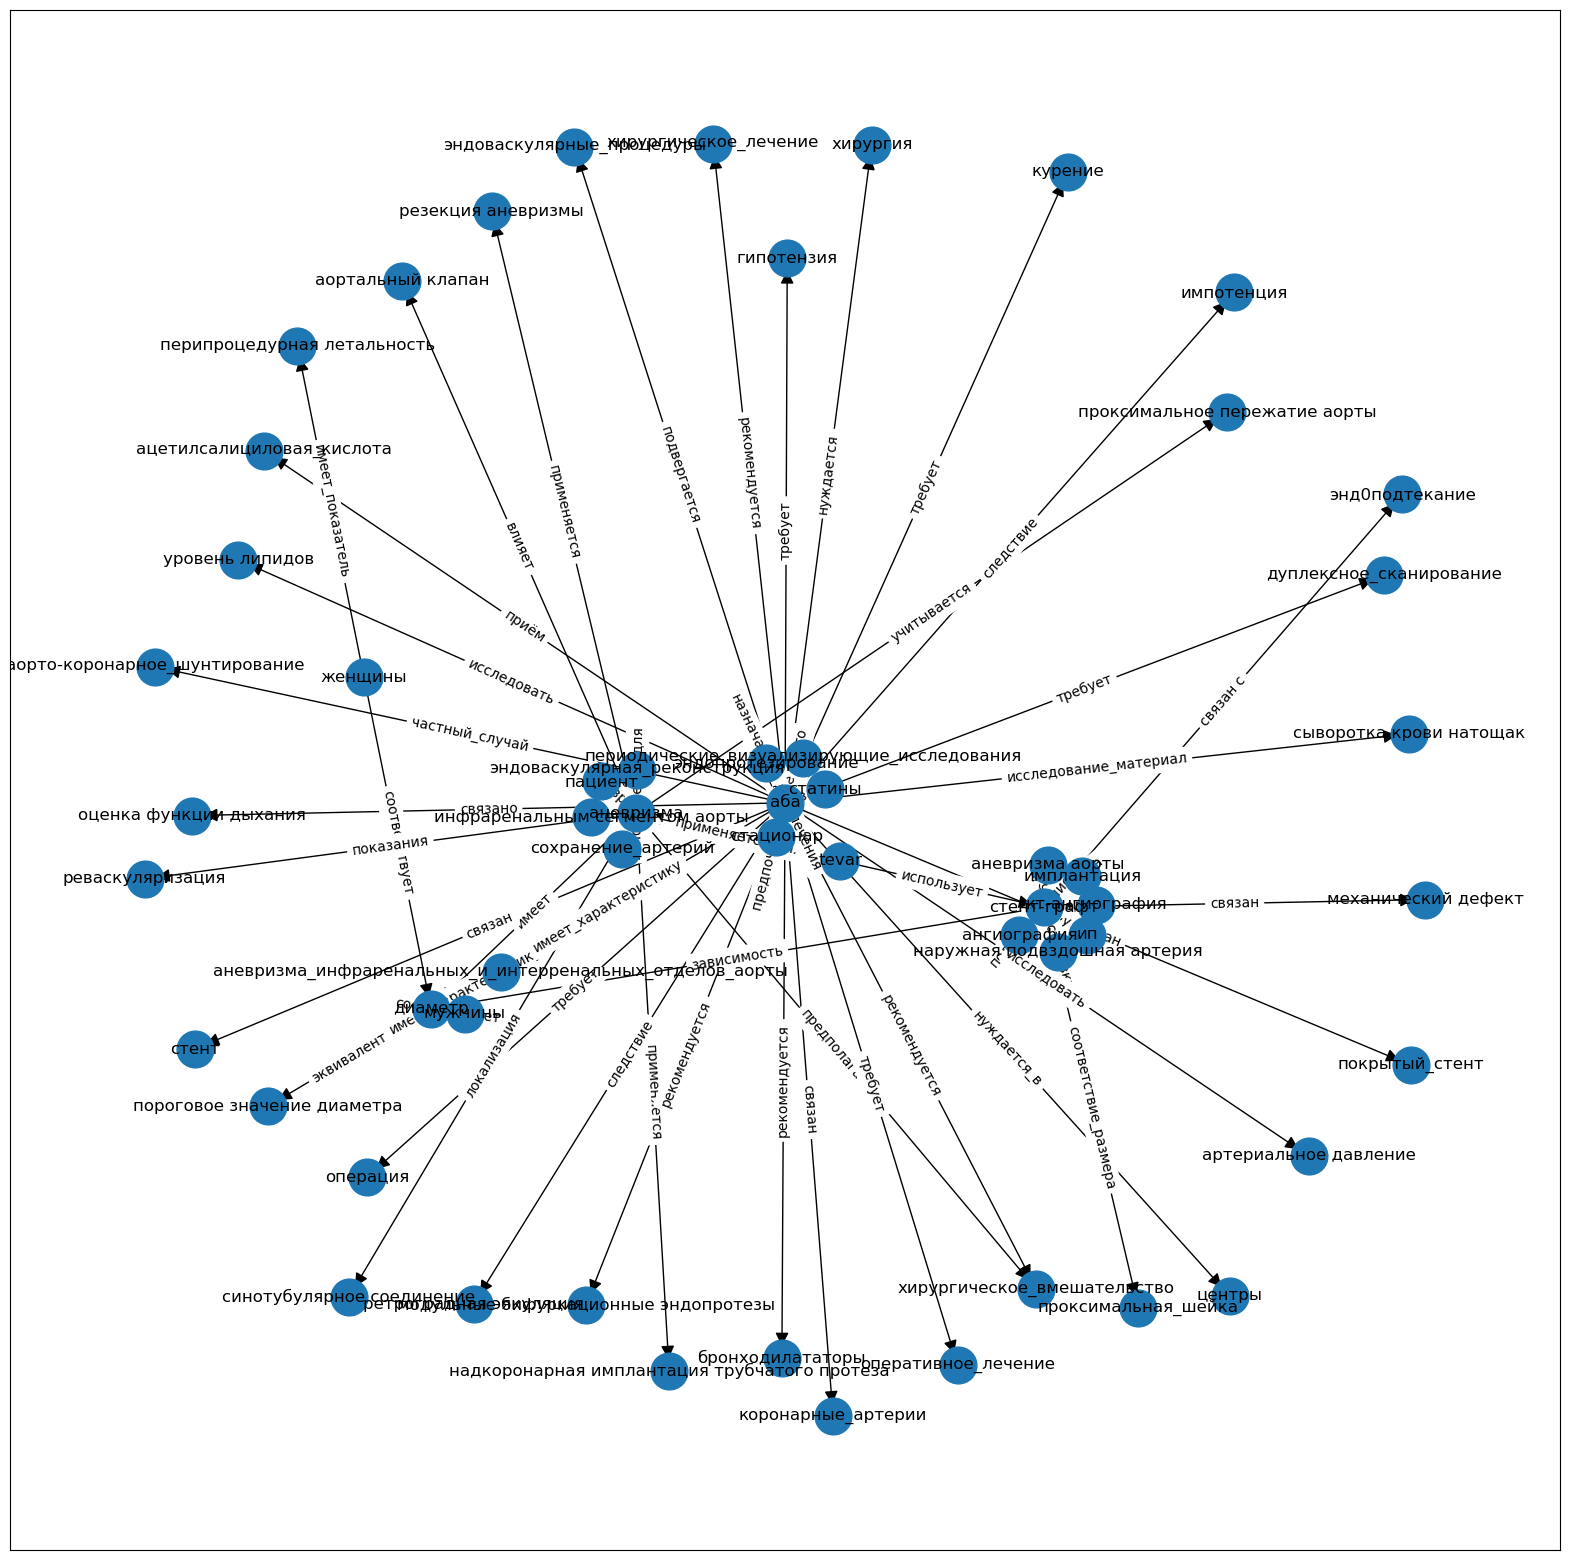

'Учитывая симптомы пациента, предполагаемый диагноз — аневризма брюшной аорты (АБА) большого диаметра. Больному требуется срочная консультация кардиохирурга для оценки состояния и планирования оперативного вмешательства. Также рекомендуется проведение дополнительных исследований и подготовка к плановой открытой хирургии. Пациенту следует отказаться от курения, соблюдать рекомендации по приёму медикаментов и контролировать артериальное давление и уровень липидов. Для выявления формирования аневризмы и оценки функции дыхания необходимо проводить периодические исследования и дуплексное сканирование.'

In [35]:
get_answer('Мужчина, АБА, диаметр 55,5 см')

['аневризма', 'диаметр', 'инфраренальный отдел брюшной аорты', 'интерренальный отдел брюшной аорты']
('аневризма', 'хирургическое_вмешательство', {'label': 'предполагает', 'desc': 'аневризма предполагает хирургическое вмешательство'})
('аневризма', 'синотубулярное соединение', {'label': 'локализация', 'desc': 'аневризма распространяется ниже синотубулярного соединения'})
('аневризма', 'реваскуляризация', {'label': 'показания', 'desc': 'реваскуляризация показана при аневризме'})
('аневризма', 'проксимальное пережатие аорты', {'label': 'учитывается', 'desc': 'проксимальное пережатие аорты учитывает распространенность аневризм'})
('аневризма', 'аортальный клапан', {'label': 'влияет', 'desc': 'аневризма оказывает влияние на вовлечение аортального клапана в процесс'})
('аневризма', 'резекция аневризмы', {'label': 'применяется', 'desc': 'применяется резекция аневризмы при лечении'})
('аневризма', 'надкоронарная имплантация трубчатого протеза', {'label': 'применяется', 'desc': 'используется м

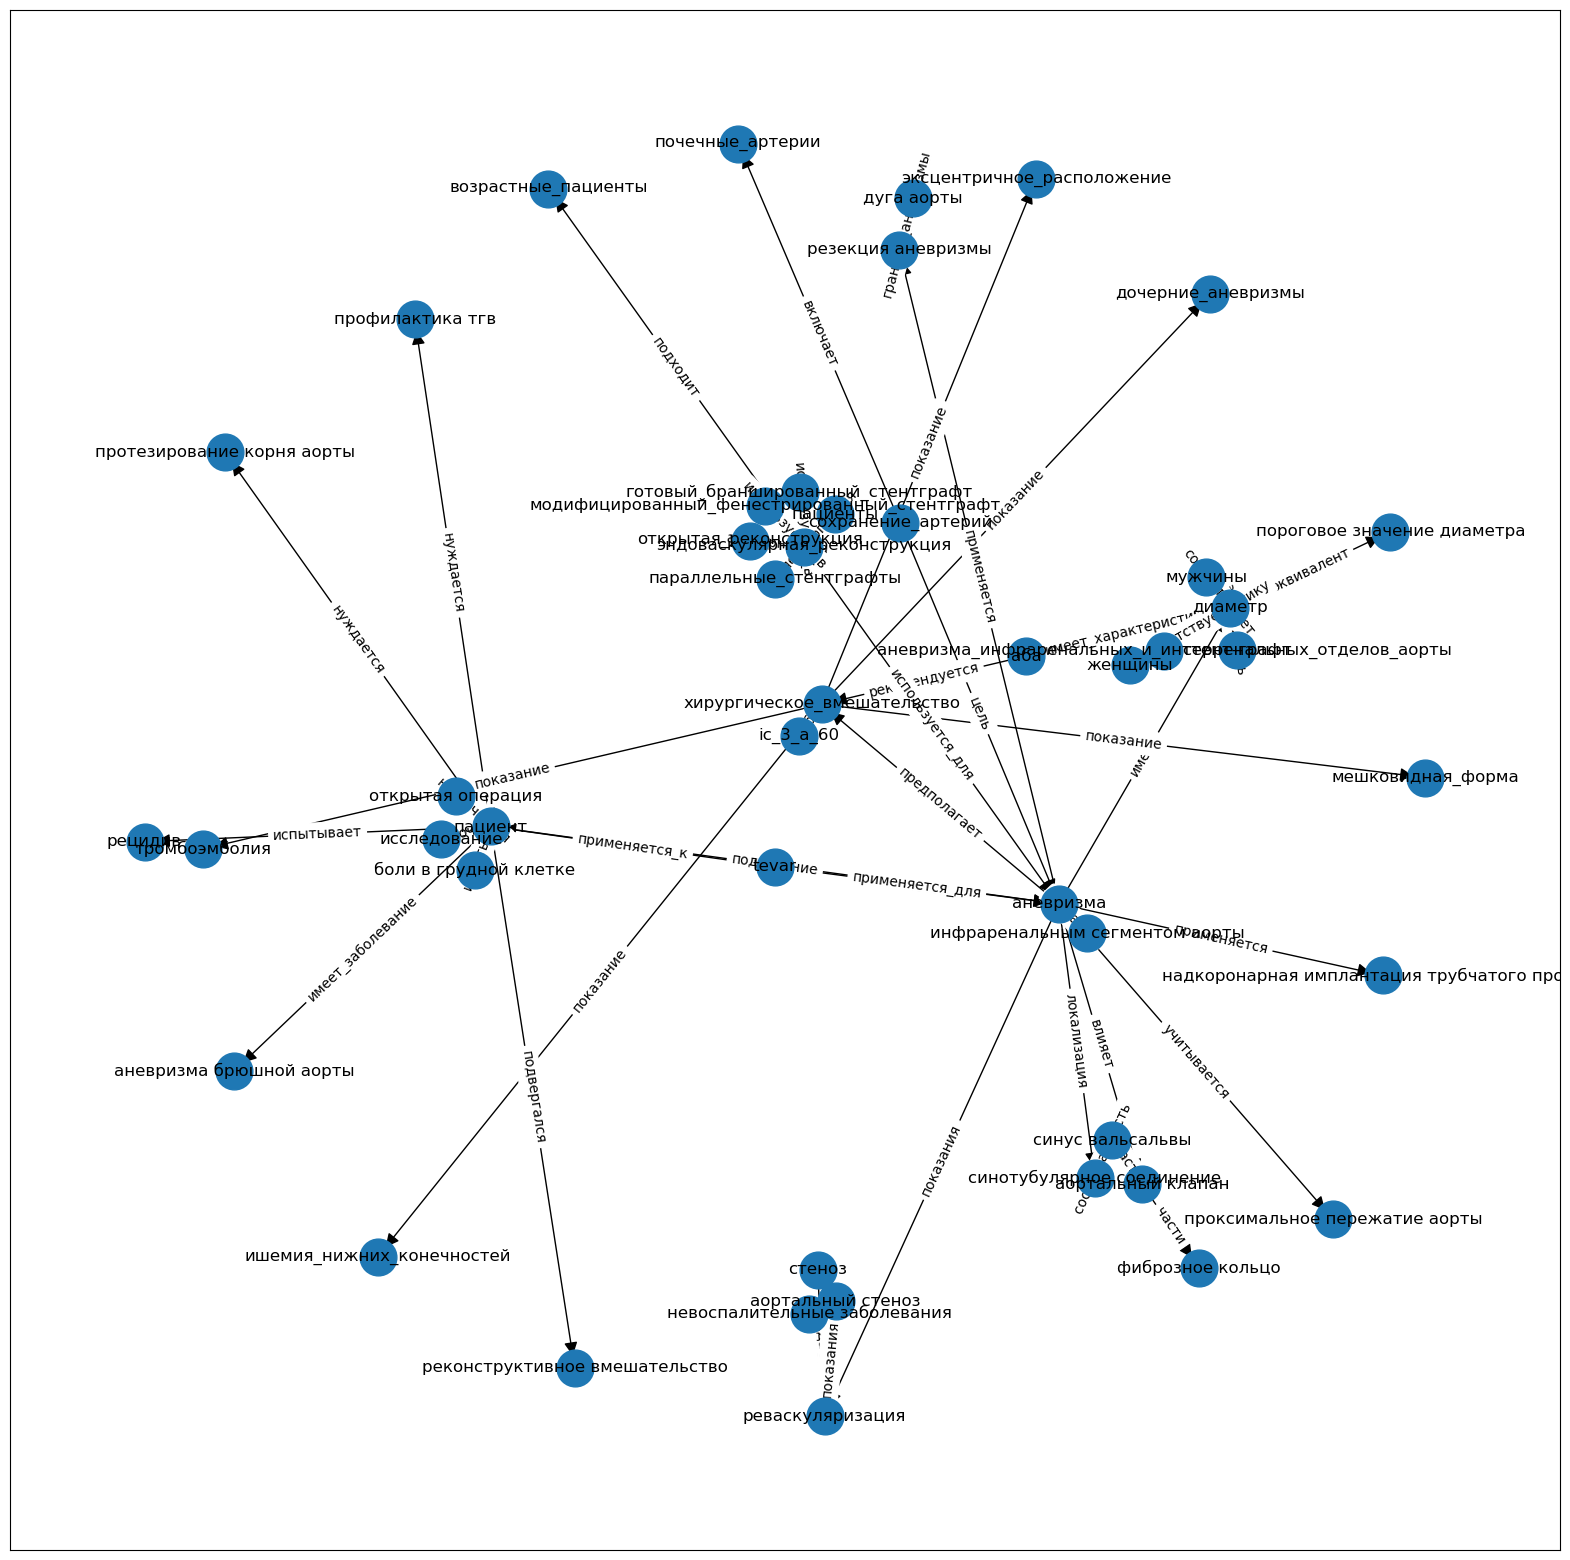

'На основании предоставленных данных и симптомов пациента, можно сделать вывод о наличии аневризмы инфраренального и интерренального отделов брюшной аорты диаметром более 4,5 см у женщин и более 5,0 см у мужчин. \n\nПациенту показано хирургическое вмешательство в связи с размером и расположением аневризмы. Рекомендуется провести открытую операцию или эндоваскулярную реконструкцию аневризмы в зависимости от общего состояния пациента и других факторов.\n\nПеред проведением операции необходимо провести дополнительные исследования для определения оптимального метода лечения и минимизации рисков. После хирургического вмешательства пациент нуждается в профилактике ТГВ и контроле за состоянием аневризмы после операции.'

In [36]:
get_answer('Аневризма инфраренального и интерренального отделов брюшной аорты диаметром более 4,5 см у женщин и более 5,0 см у мужчин')

['диаметр', 'аневризма']
('диаметр', 'пороговое значение диаметра', {'label': 'эквивалент', 'desc': 'пороговым значением диаметра является 5-5,5см'})
('аневризма_инфраренальных_и_интерренальных_отделов_аорты', 'диаметр', {'label': 'имеет_характеристику', 'desc': 'аневризма имеет определённый размер'})
('стент-графт', 'энд0подтекание', {'label': 'связан с', 'desc': 'стент-графт связан с возможным эндоподтеканием'})
('стент-графт', 'механический дефект', {'label': 'связан', 'desc': 'стент-графт связан с механическим дефектом'})
('стент-графт', 'проксимальная_шейка', {'label': 'соответствие_размера', 'desc': 'диаметр стент-графта должен превышать диаметр проксимальной шейки на 10–20%'})
('стент-графт', 'диаметр', {'label': 'зависимость', 'desc': 'диаметр стент-графта зависит от диаметра аорты и составляет 10-20% больше диаметра проксимальной шейки'})
('ип', 'стент-графт', {'label': 'требуется', 'desc': 'стент-графт устанавливается в ип с помощью проводника'})
('кт-ангиография', 'стент-гра

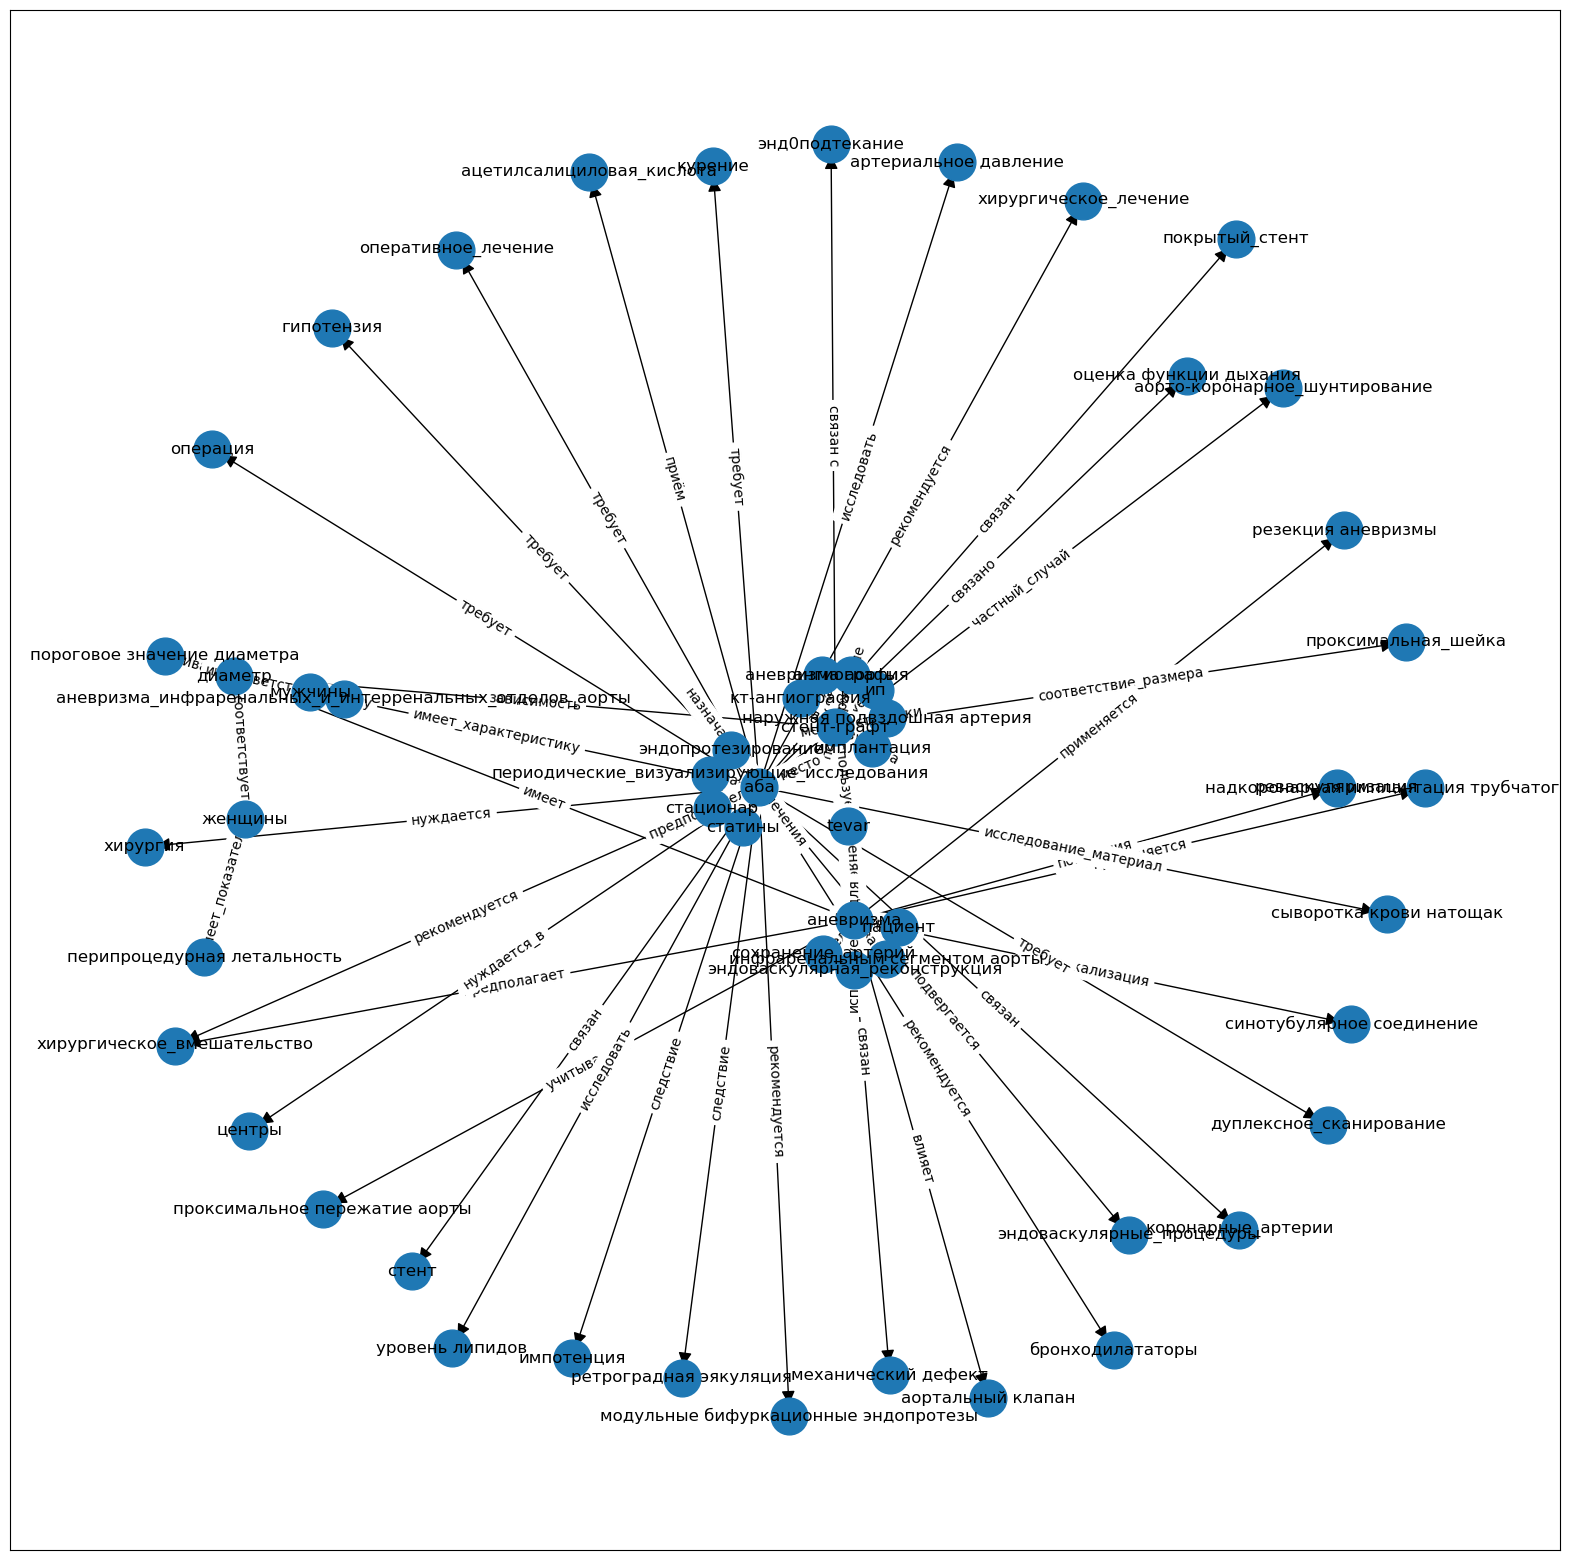

'Учитывая диаметр аневризмы 5 см, что соответствует мужскому показателю и превышает пороговое значение в 5-5,5 см (для женщин), рекомендуется хирургическое вмешательство. Для более детальной оценки состояния пациентки и планирования операции необходимо провести дополнительные исследования, включая КТ-ангиографию.'

In [38]:
get_answer('Женщина с диаметром аневризмы 5 см')

['аневризма', 'АБА', 'состояние']
('аневризма', 'хирургическое_вмешательство', {'label': 'предполагает', 'desc': 'аневризма предполагает хирургическое вмешательство'})
('аневризма', 'синотубулярное соединение', {'label': 'локализация', 'desc': 'аневризма распространяется ниже синотубулярного соединения'})
('аневризма', 'реваскуляризация', {'label': 'показания', 'desc': 'реваскуляризация показана при аневризме'})
('аневризма', 'проксимальное пережатие аорты', {'label': 'учитывается', 'desc': 'проксимальное пережатие аорты учитывает распространенность аневризм'})
('аневризма', 'аортальный клапан', {'label': 'влияет', 'desc': 'аневризма оказывает влияние на вовлечение аортального клапана в процесс'})
('аневризма', 'резекция аневризмы', {'label': 'применяется', 'desc': 'применяется резекция аневризмы при лечении'})
('аневризма', 'надкоронарная имплантация трубчатого протеза', {'label': 'применяется', 'desc': 'используется метод надкоронарной имплантации трубчатого протеза при лечении'})
('

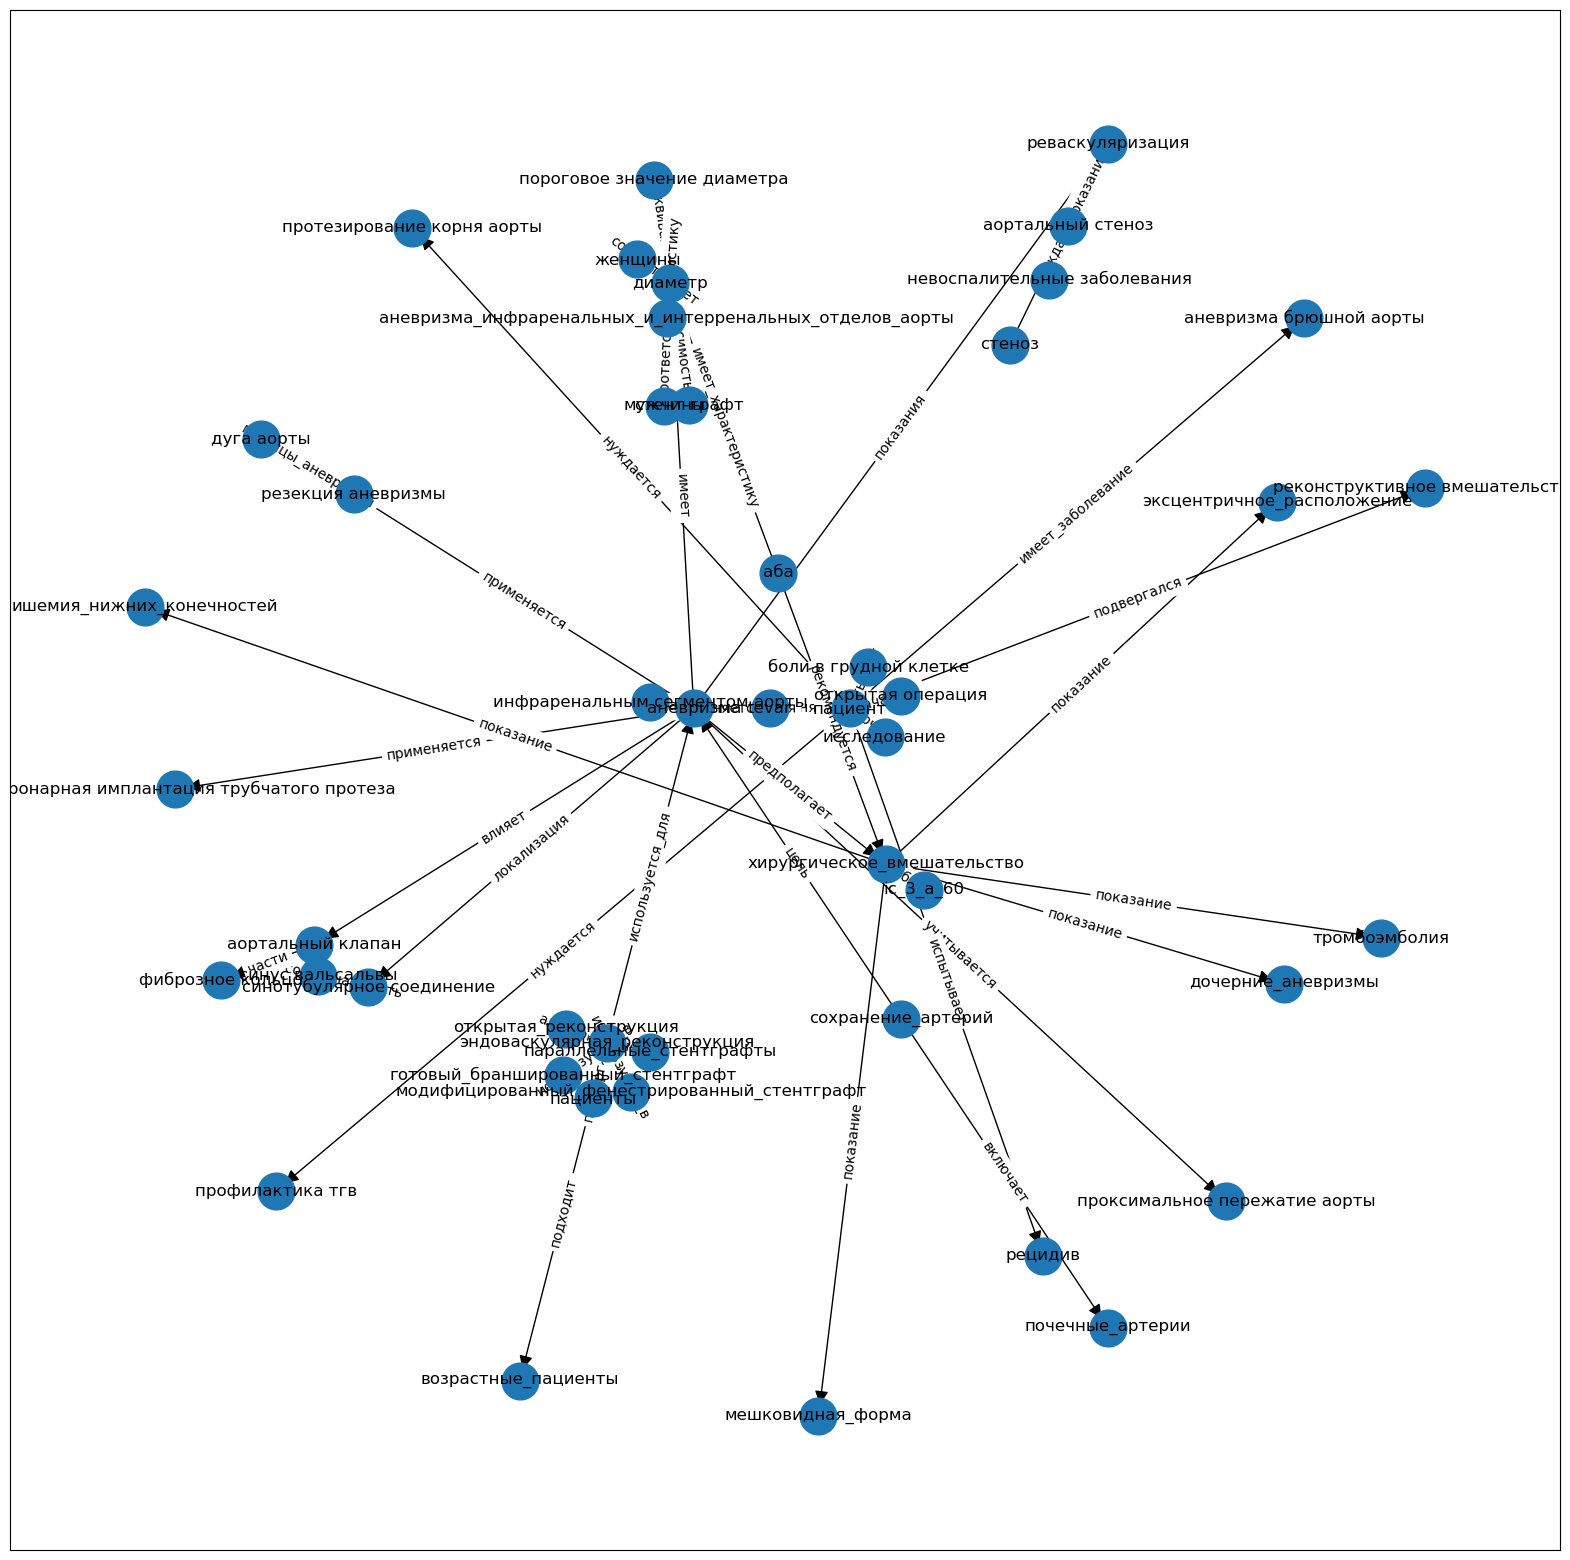

'На основании предоставленных данных и учитывая симптомы больного, можно сделать вывод о необходимости хирургического вмешательства. Рекомендую провести более детальное обследование для определения размера аневризмы, её расположения и общего состояния пациента.\n\nВ зависимости от результатов обследования, может быть рекомендовано либо открытое хирургическое вмешательство, либо эндоваскулярная реконструкция аневризмы. Также пациенту необходима профилактика тромбоэмболических осложнений после операции.'

In [41]:
get_answer('рАБА, тяжелое состояние')